# STEP50 ミニバッチを取り出すDataLoader

## このステップの概要

### 前のステップ、STEP49で学んだこと

Datasetクラスを作り、指定されたインターフェイスでデータセットにアクセス可能なしくみを作った

### STEP50の目的

- `Dataset`クラスから **ミニバッチ** を作るクラスを`DataLoader`として実装する
- この`DataLoader`クラスには**ミニバッチの作成**や**データセットのシャフル**などの仕事を行わせる
    - これにより、ユーザの書く学習コードはよりシンプルになるご利益がある

内容

- 50.1 イテレータとは
    - 一般的なイテレータの理解
- 50.2 DataLoaderを使う
    - `dezero/dataloaders.py`に `DataLoader()`クラスの実装
    - DataLoaderクラスに上記で学んだイテレータの機能を実装する
- 50.３ accuracy関数の実装
    - `dezero/fucntions.py`に `accuracy()`関数の実装
- 50.4 スパイラル データセットの学習コード
    - STEP49でも実行したSpiralデータセットを用いて、学習用のコードがどのように便利になるか確認する

これまで何をやったか、まとめています。目次より、少し詳しい情報となっています。

https://qiita.com/daikumatan/private/1c4ba888ed1928c55fb2

## 事前準備

In [ ]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import math
import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero import optimizers
from dezero import Variable
from dezero import as_variable, as_array
import dezero.functions as F
from dezero.models import MLP

## 50.1 イテレータとは

### イテレータとは

- 日本語で反復子と約される
- 要素を反復して取り出すことができる
- Pythonにおいてはlistやtapleなどの複数の要素を持つデータ型を順番にデータを取り出す機能を提供する


### イテレータのサンプルコード説明

- リストをイテレータに変換するには`iter()`関数を使う
- 以下は`t`というリストから`x`というイテレータを作っている
- イテレータで順番にデータを取り出すには`next()`関数が使われる

In [19]:
t = [1, 2, 3]
x = iter(t)
next(x)

1

次の値はもう一度`next()`をコール

In [20]:
next(x)

2

更にもう一度`next()`をコール

In [21]:
next(x)

3

In [23]:
#これはエラーがでる
#next(x)

### 俺々イテレータ DeZeroに実装する前の準備体操

- `__iter__`という特集メソッドを実装し、そこで自分自身(self)を返す `retun self`
- `__next__`という特殊メソッドで、次の要素を返す
    - この例では1を足すだけ
- もし返す要素がなければ `raise StopIteration()`とする
    - `__next__` メソッドを抜ける
- `for x in obj:`という構文で要素の取り出し可能

In [27]:
class MyIterator:
    def __init__(self, max_cnt):
        self.max_cnt = max_cnt  # 最大繰り返し回数
        self.cnt = 0            # イタレーションの回数  

    def __iter__(self):
        print("__iter__")
        return self
    
    def __next__(self):
        print("__next__")
        if self.cnt == self.max_cnt:
            # print("StopIteration")
            # raiseが呼ばれるとこの関数を抜けます
            print("StopIteration")
            raise StopIteration()

        self.cnt += 1
        #print("next self.cnt", self.cnt)
        return self.cnt


In [28]:
obj = MyIterator(5)
print("---- instance is created ----")
for x in obj:
    print(x)

---- instance is created ----
__iter__
__next__
1
__next__
2
__next__
3
__next__
4
__next__
5
__next__
StopIteration


### DeZeroのミニバッチを取り出す `DataLoader`クラスの実装

- 先程の俺々イテレータを応用して `DataLoader` クラスを作成してみる
- これは与えられたデータセットを先頭から取り出し、必要に応じてデータセットのシャフルを行う


```python
class DataLoader:
    def __init__(self, dataset, batch_size, shuffle=True, gpu=False):
        """
        引数をインスタンス変数に格納する。
        その後resetメソッドを呼び出し、イタレーションの回数を0に設定する。必要に応じてShuffleする。
        """
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data_size = len(dataset)
        self.max_iter = math.ceil(self.data_size / batch_size)
        self.gpu = gpu

        self.reset()

    def reset(self):
        """
        インスタンス変数のiterationの回数を0に設定
        必要に応じてShuffleする。Shuffleは、np.random.permutationによって実現されており
        i = len(self.dataset)とすると、0 から i-1までの数値の列を作成しそれを、ランダムに並び替えている
        self.indexのサイズは全データ数分ある(実装として、そのメモリ分はちゃんと使うので注意)
        """
        self.iteration = 0
        if self.shuffle:
            self.index = np.random.permutation(len(self.dataset))
        else:
            self.index = np.arange(len(self.dataset))

    def __iter__(self):
        """
        ループ処理が呼び出された最初のみ実行される。繰り返し中は実行されないことに注意
        """
        return self

    def __next__(self):
        """
        ミニバッチをデータから抽出し、それをndarrayインスタンスへと変換する。抽出するデータの範囲は、以下のようになる。
        - Start: i * batch_size:(i + 1)
        -   End: (i + 1) * batch_size
        self.indexは, shuffle=True のときランダムに並んでいることに注意する
        self.iterationがself.max_iter (ステップ数、1エポックあたりのバッチの回数)を超えると、
        raise StopIteration で、この関数を抜ける
        """
        if self.iteration >= self.max_iter:
            self.reset()
            raise StopIteration

        i, batch_size = self.iteration, self.batch_size
        batch_index = self.index[i * batch_size:(i + 1) * batch_size]
        batch = [self.dataset[i] for i in batch_index]

        #xp = cuda.cupy if self.gpu else np
        #x = xp.array([example[0] for example in batch])
        #t = xp.array([example[1] for example in batch])
        
        x = np.array([example[0] for example in batch])
        t = np.array([example[1] for example in batch])
        self.iteration += 1
        return x, t

    def next(self):
        return self.__next__()

    def to_cpu(self):
        self.gpu = False

    def to_gpu(self):
        self.gpu = True
```

## 50.2 DataLoaderを使う

- 訓練用のデータローダはエポック毎にデータのシャフルを行うので、`shuffle=True` とした(デフォルト設定)
- 一方、テスト用のデータローダは精度の評価のみに使用するので、`shuffle=False` と設定した
- ミニバッチの取り出しやデータのシャフルをこのデータローダに任せることができた。

In [29]:
from symbol import testlist_comp
from dezero.datasets import Spiral
from dezero import DataLoader

batch_size = 10
max_eporch = 1

# train=True|False はテストデータ作成時の乱数のseed値が変わるだけ
train_set = Spiral(train=True)
test_set = Spiral(train=False)

# これで、バッチ用データ生成の準備完了
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

# エポックループは、train_setとtest_setどちらも内包することに注意
for epoch in range(max_eporch):
    # ここでトレイン用のバッチデータの生成
    for x, t in train_loader:
        # 訓練データの表示
        print(x)
        print(t)
        print(x.shape, t.shape)
        break

    # エポックの終わりにテストデータを取り出す
    for x, t in test_loader:
        # テストデータの表示
        print(x.shape, t.shape)
        break

/var/folders/ks/1lmhz0ts5mn9yqg_s5ngt53h0000gp/T/ipykernel_26187/4012415275.py:1: DeprecationWarning: The symbol module is deprecated and will be removed in future versions of Python
  from symbol import testlist_comp


[[ 0.662295    0.3070266 ]
 [-0.4507611  -0.3649855 ]
 [-0.29891637 -0.75282735]
 [ 0.1297094  -0.15223493]
 [-0.24501143  0.04969303]
 [ 0.43561164 -0.45512912]
 [-0.          0.        ]
 [ 0.5703474   0.5609847 ]
 [ 0.05997716 -0.00165524]
 [-0.05060399 -0.427012  ]]
[1 2 0 2 1 0 0 1 2 2]
(10, 2) (10,)
(10, 2) (10,)


## 50.３ accuracy関数の実装

ここでは、認識精度を評価するための`accuracy()`関数を実装する

- `accuracy`関数は引数`y`と`t`の「正答率」を算出する
    - `y`: ニューラルネットワークの予測結果
    - `t`: 正解データ
- この２つの引数は`Variable`もしくは`ndarray`インスタンスとする
- `argmax(axis=1)`で各行における最大となるindexを返す
    - e.g.) [0.2, 0.8, 0], [0.1, 0.9, 0], [0.8, 0.1, 0.1] => [1, 1, 0]
- `reshape(t.shape)` で`t.shape` と同様の型にしている
- `result = (pred == t.data)` を実行すると `result=[True False  True]` のような結果を得る
    - `True` の部分は正解しているということ
- `acc = result.mean()` において`Trueの数/len(result)` を計算してやっている

```python
def accuracy(y, t):
    """
    [WAR] この関数は微分できません。
    """
    y, t = as_variable(y), as_variable(t)

    pred = y.data.argmax(axis=1).reshape(t.shape)
    result = (pred == t.data)
    acc = result.mean()
    return Variable(as_array(acc))
```

In [34]:
# function.pyには、accuracyの名前で実装されている。区別するためにaccuracy_notebookという関数名にした
# 挙動をわかりやすくするため、print文を挿入している
from dezero import Variable, as_variable, as_array
def accuracy_notebook(y, t):
    y, t = as_variable(y), as_variable(t)
    print("t.shape:", t.shape)
    pred = y.data.argmax(axis=1).reshape(t.shape)
    print(f"---- without shape ----\n{y.data.argmax(axis=1)}")
    print(f"---- with shape ----\n{pred}")
    result = (pred == t.data)
    print(result)
    acc = result.mean()
    return Variable(as_array(acc))

理解のために`t`のコメントアウトを有効にすると挙動がわかりやすい。`reshape(t.shape)` の働きがイメージできるようになる

In [44]:
import numpy as np
import dezero.functions as F

# 3つのクラス分類のイメージ, 例えば[A, B, C] = [0, 1, 2]
# - yは左からB, B, Aという回答 (最大値の要素番号) => [1, 1, 0]]
# - tはその時の正解であり、B, C, Aという回答になっている。=> [1, 2, 0]
y = np.array([[0.2, 0.8, 0], [0.1, 0.9, 0], [0.8, 0.1, 0.1]])
t = np.array([1, 2, 0])

# tの形状にあわせて,出力形状を変更してくれる。コメントアウトを外すとそれを確認できる。
#t = np.array([[1],[2],[0]])

# 上記で説明したyの途中演算結果:[1, 1, 0] と t:[1, 2, 0] を比較すると [True, False, True]
# 精度を計算 => [True, False, True] => 2/3 = 0.6666...
acc = accuracy_notebook(y, t)
acc

t.shape: (3,)
---- without shape ----
[1 1 0]
---- with shape ----
[1 1 0]
[ True False  True]


variable(0.6666666666666666)

## 50.4 スパイラル データセットの学習コード




In [45]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero import DataLoader
from dezero.models import MLP


max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

train_loss_history = []
train_accuracy_history = []
valid_loss_history = []
valid_accuracy_history = []
iepoch = []

train_set = dezero.datasets.Spiral(train=True)
test_set = dezero.datasets.Spiral(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

for epoch in range(max_epoch):
    sum_loss, sum_acc = 0, 0

    for x, t in train_loader:                   # 訓練用のミニバッチデータ
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)                  # 訓練データの認識精度
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)

    size_tmp = len(train_set)
    loss_tmp = sum_loss / size_tmp
    acc_tmp = sum_acc / size_tmp
    train_loss_history.append(loss_tmp)
    train_accuracy_history.append(acc_tmp)

    print('epoch: {}'.format(epoch+1))
    print('train loss: {:.4f}, accuracy: {:.4f}'.format(loss_tmp, acc_tmp))

    sum_loss, sum_acc = 0, 0
    with dezero.no_grad():                      # 勾配不要モード
        for x, t in test_loader:                # テスト用のミニバッチデータ
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y, t)              # テスト用データの認識精度
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)

    size_tmp = len(test_set)
    loss_tmp = sum_loss / size_tmp
    acc_tmp = sum_acc / size_tmp
    valid_loss_history.append(loss_tmp)
    valid_accuracy_history.append(acc_tmp)

    iepoch.append(epoch + 1)
    print('test loss: {:.4f}, accuracy: {:.4f}'.format(loss_tmp, acc_tmp))


epoch: 1
train loss: 1.0944, accuracy: 0.4033
test loss: 1.0468, accuracy: 0.3267
epoch: 2
train loss: 0.9882, accuracy: 0.4933
test loss: 0.9729, accuracy: 0.4333
epoch: 3
train loss: 0.9403, accuracy: 0.5133
test loss: 0.8965, accuracy: 0.6233
epoch: 4
train loss: 0.8820, accuracy: 0.5700
test loss: 0.8771, accuracy: 0.5967
epoch: 5
train loss: 0.8617, accuracy: 0.5600
test loss: 0.8670, accuracy: 0.5867
epoch: 6
train loss: 0.8313, accuracy: 0.5300
test loss: 0.8654, accuracy: 0.6000
epoch: 7
train loss: 0.8086, accuracy: 0.5833
test loss: 0.7950, accuracy: 0.5600
epoch: 8
train loss: 0.7948, accuracy: 0.5733
test loss: 0.7921, accuracy: 0.5900
epoch: 9
train loss: 0.7728, accuracy: 0.5500
test loss: 0.7718, accuracy: 0.5300
epoch: 10
train loss: 0.7643, accuracy: 0.5633
test loss: 0.7796, accuracy: 0.5800
epoch: 11
train loss: 0.7862, accuracy: 0.5600
test loss: 0.7701, accuracy: 0.5633
epoch: 12
train loss: 0.7914, accuracy: 0.5500
test loss: 0.8218, accuracy: 0.6067
epoch: 13
tra

<function matplotlib.pyplot.show(close=None, block=None)>

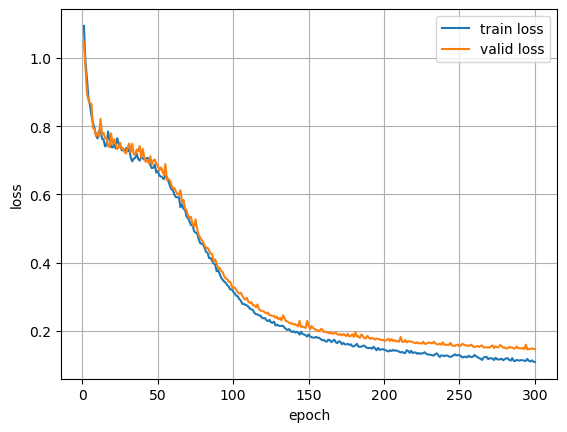

In [46]:
import numpy as np
import matplotlib.pyplot as plt


plt.plot(iepoch, train_loss_history, label=f"train loss")
plt.plot(iepoch, valid_loss_history, label=f"valid loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

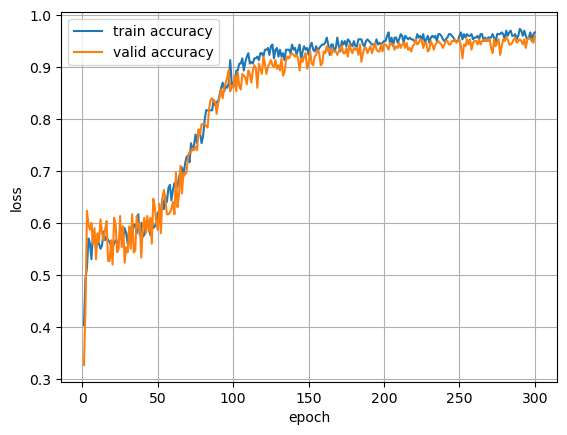

In [47]:
import numpy as np
import matplotlib.pyplot as plt


plt.plot(iepoch, train_accuracy_history, label=f"train accuracy")
plt.plot(iepoch, valid_accuracy_history, label=f"valid accuracy")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show

## 補足

In [48]:
train = False
seed = 1984 if train else 2020
seed

2020

### `numpy.random.permutation()` 関数

In [49]:
import numpy as np
np.random.permutation(10)

array([8, 7, 9, 4, 1, 5, 0, 6, 2, 3])

In [50]:
np.random.permutation([1, 2, 3, 4, 5, 6 ,7])

array([1, 7, 3, 6, 5, 2, 4])

### `raise` 文

- 意図的に例外を発生させることができます。
- try...except文でキャッチできます。

In [51]:
try:
	a = 100/10
	raise Exception('例外のテスト')
except Exception as e:
	print(e) # 例外のテスト

print("Next code")

例外のテスト
Next code


### `exception StopIteration`

- 組込み関数 `next()` と iterator の `__next__()` メソッドによって、そのイテレータが生成するアイテムがこれ以上ないことを伝えるために送出されます。

In [52]:
try:
    raise StopIteration("test")
except StopIteration as e:
    print(e)

test


### `numpy.argmax()`

In [53]:
import numpy as np
a = np.random.randint(10, size = 10)
print(a)
print(np.argmax(a))
print(a.argmax())

[7 3 2 9 2 2 3 8 8 4]
3
3


In [54]:
b = np.random.randint(10, size = (3,4))
print(b)
print("axis=0:", np.argmax(b, axis=0))
print("axis=1:", np.argmax(b, axis=1))
print("axis=0:", b.argmax(axis=0))
print("axis=1:", b.argmax(axis=1))

[[0 3 7 9]
 [1 4 4 3]
 [8 1 0 6]]
axis=0: [2 1 0 0]
axis=1: [3 1 0]
axis=0: [2 1 0 0]
axis=1: [3 1 0]


### `reshape()`の使い方

In [55]:
a = np.arange(24)
print(a)
a46 = a.reshape([4, 6])

print(a46)
print(a46.shape)
print(a46.ndim)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]]
(4, 6)
2
